# <center> Understanding CNN feature recognition by visualizing its feature maps </center>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from urllib.request import urlopen
from PIL import Image
import scipy
import os

In [33]:
def read_image_from_url(url):
    return Image.open(urlopen(url))

def preprocess_image(image, target_size=(224,224)): # image must be read using the Image module
    if type(image)==str:
        try:
            img = tf.keras.preprocessing.image.load_img(image, target_size=target_size)
        except OSError: # If invalid argument
            img = read_image_from_url(image).resize(target_size, Image.BILINEAR)
    else:
        img = image.resize(target_size, Image.BILINEAR)
        
    img = np.expand_dims(np.array(img), axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

def create_VGG16(input_shape=None, classes=1000):
    include_top=True if classes==1000 else False
    model = tf.keras.applications.VGG16(
        include_top=include_top,
        weights="imagenet",
        input_tensor=None,
        input_shape=input_shape,
        pooling=None,
        classes=classes,
        classifier_activation="softmax")
    return model

def get_layers_outputs(model, layer_idx, target_image):
    outputs = [model.layers[idx].output for idx in layer_idx]
    names = set([model.layers[idx].name for idx in layer_idx])
    model = tf.keras.models.Model(inputs=model.inputs, outputs=outputs)
    print("Selected layers: {}".format(names))
    output = model.predict(target_image)
    return output

def plot_feature_map(layer_output, features_to_show=None, cmap='magma', figsize = (12, 12), ax=None, inloop=False):
    n_features = features_to_show if features_to_show is not None else layer_output.shape[-1]
    sides = np.ceil(np.sqrt(n_features)).astype(int)
    if ax is None:
        _, ax = plt.subplots(sides-1, sides, figsize=figsize) if sides**2>n_features \
                                                              else plt.subplots(sides, sides, figsize=figsize)

        plt.suptitle("{} features".format(n_features), y=0.91)
        for ax_ in ax.ravel():
            ax_.set_axis_off()
        for i in range(n_features):
            ax.ravel()[i].imshow(layer_output[:,:,i], cmap=cmap)   
    else:
        for i, ax_ in enumerate(ax.ravel()):
            ax_.imshow(layer_output[:,:,i], cmap=cmap)
    
    if not inloop:
        plt.show()
        
def pipeline(image, model, layer_idx, features_to_show=None, target_size=(224, 224), cmap='magma', figsize=(12, 12), 
                                                                                            ax=None, inloop=False):
    input_img = preprocess_image(image, target_size)
    outputs = get_layers_outputs(model, layer_idx, input_img)

    if len(outputs)==1:
        for idx in range(len(outputs)):
            plot_feature_map(outputs[idx], features_to_show, cmap, figsize, ax, inloop)
    else:
        for idx in range(len(outputs)):
            outputs[idx] = outputs[idx][0, :, :, :]
            plot_feature_map(outputs[idx], features_to_show, cmap, figsize, ax, inloop)

In [3]:
path = "../Data/Animal_Image_Dataset/animals"

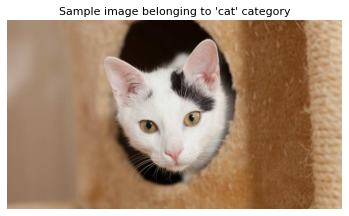

In [4]:
label = 'cat'
infile = "00357563a7.jpg"
img_path = "{}/{}/{}".format(path, label, infile)

cat_image = Image.open(img_path)
_, ax = plt.subplots()
ax.imshow(cat_image)
ax.axis('off')
ax.set_title("Sample image belonging to '{}' category".format(label), fontsize=11)
plt.show()

In [5]:
model = create_VGG16()

In [ ]:
tf.keras.utils.plot_model(model, to_file="../Plots/VGG16_architecture.jpeg", show_shapes=True, show_layer_names=True)

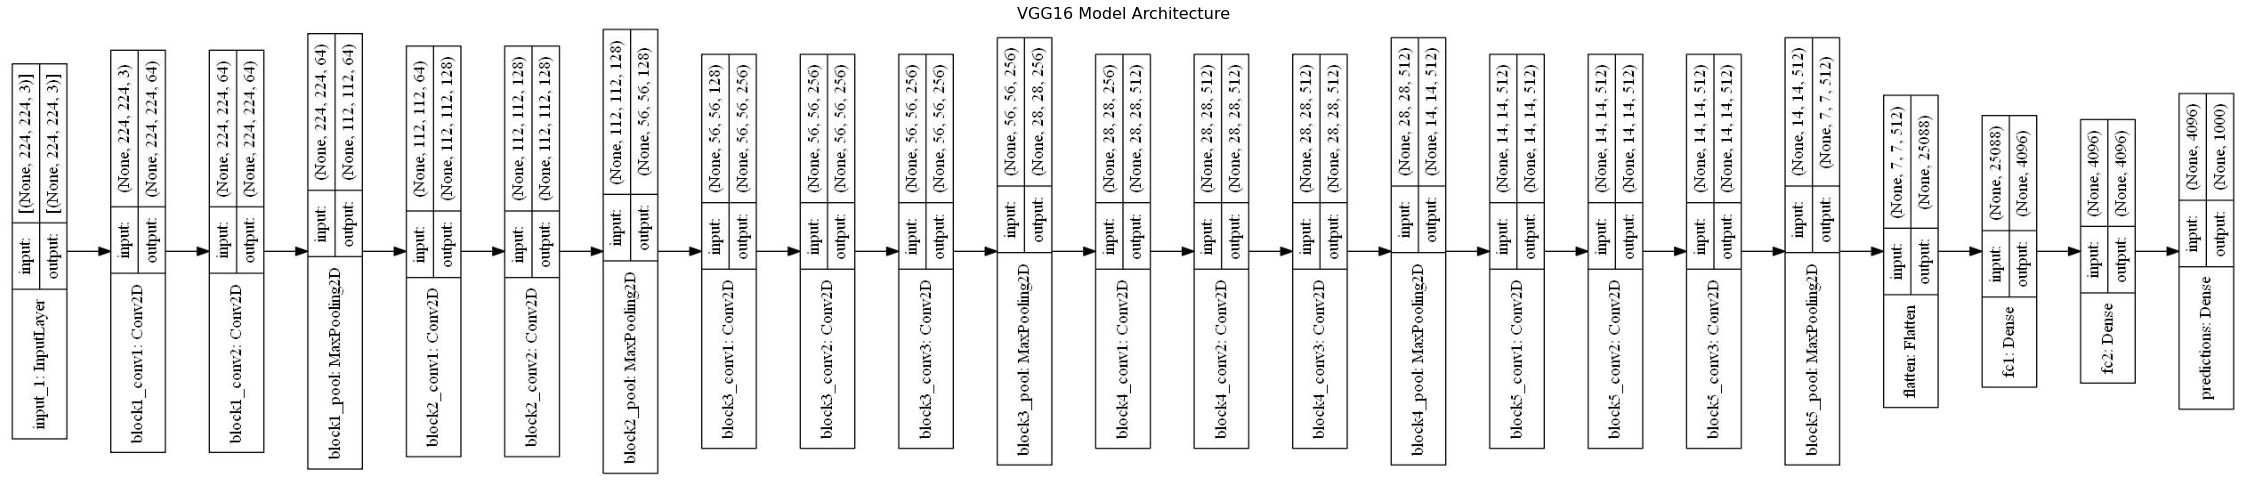

In [7]:
_, ax = plt.subplots(figsize=(40, 10))
vgg16_arch = Image.open("../Plots/VGG16_architecture.jpeg")
ax.imshow(scipy.ndimage.rotate(vgg16_arch, 90))
ax.axis('off')
ax.set_title("VGG16 Model Architecture", fontsize=16)
plt.show()

Selected layers: {'block1_conv2', 'block2_conv2'}


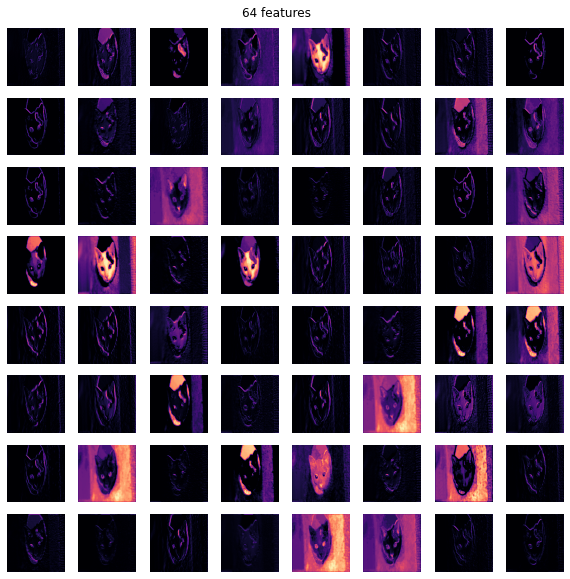

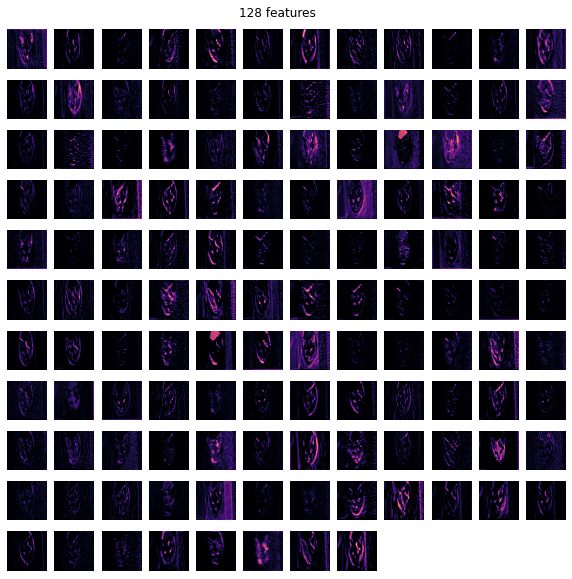

In [282]:
pipeline(img_path, model, [2, 5], figsize=(10, 10))

Selected layers: {'block1_conv1'}
Selected layers: {'block2_conv1'}
Selected layers: {'block3_conv1'}
Selected layers: {'block4_conv1'}
Selected layers: {'block5_conv3'}


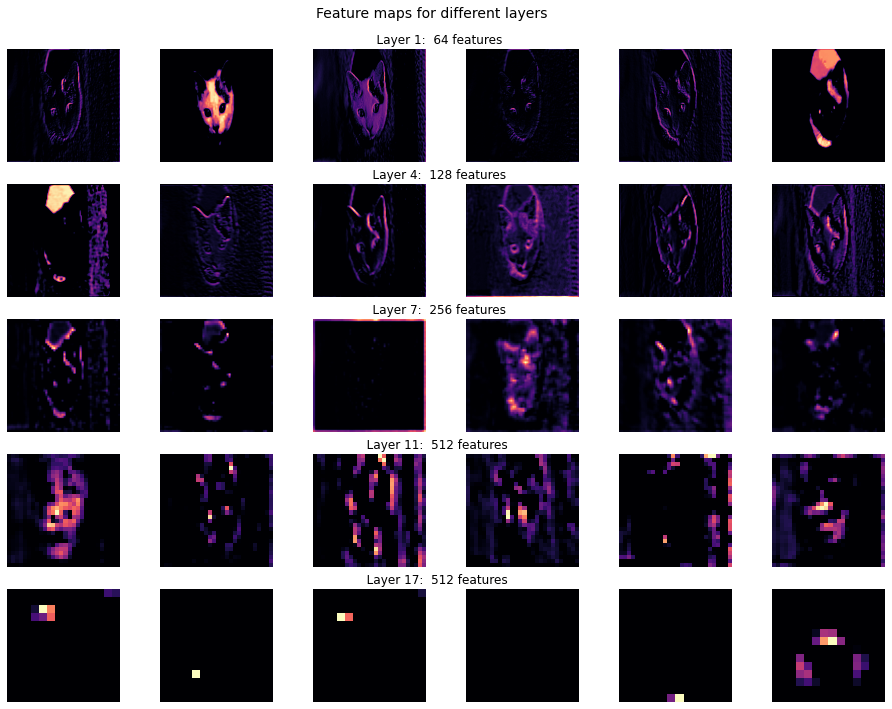

In [281]:
layer_idx = [1, 4, 7, 11, 17]
_, ax = plt.subplots(5, 6, figsize=(16, 12))
[ax_.axis('off') for ax_ in ax.ravel()] # Hide axis

for i in range(len(layer_idx)):
    ax[i,2].set_title("{:>45} {} features".format(f"Layer {layer_idx[i]}: ", (2**(6+i) if i<4 else 2**9)))
    pipeline(img_path, model, [layer_idx[i]], 6, ax=ax[i], inloop=True)
    
plt.suptitle("Feature maps for different layers", y=0.93, fontsize=14)
plt.show()

In [224]:
predicted = model.predict(preprocess_image(img_path))

In [225]:
class_id, labels, prob = np.array(tf.keras.applications.vgg16.decode_predictions(predicted, top=1000)).reshape(-1, 3).T
prob = prob.astype(float)
possible_labels = set(filter(lambda x: True if ('_cat' in x) or ('dog' in x and x!='hotdog') or \
                        ('tiger' in x and 'tiger_' not in x) else False, labels))

print(possible_labels)

{'Persian_cat', 'dogsled', 'Maltese_dog', 'French_bulldog', 'Madagascar_cat', 'Shetland_sheepdog', 'Bernese_mountain_dog', 'Siamese_cat', 'African_hunting_dog', 'tiger', 'Egyptian_cat', 'Old_English_sheepdog', 'tiger_cat', 'Eskimo_dog', 'Greater_Swiss_Mountain_dog'}


In [278]:
gen_color = lambda : [np.round(x, 1) for x in np.random.rand(3)] # generate random colors
colors=[gen_color() for i in range(10)]

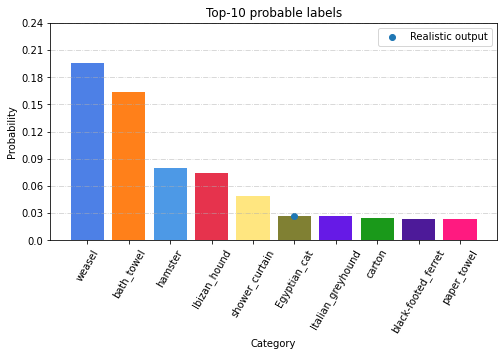

In [279]:
_, ax = plt.subplots(figsize=(8, 4))

ax.bar(x=labels[:10], height=prob[:10], color=colors)
pos_lab = list(filter(lambda x: x in possible_labels, labels[:10]))
pos_prob = [p for lab, p in zip(labels[:10], prob[:10]) if lab in pos_lab]
ax.scatter(x=pos_lab, y=pos_prob, marker='o', label="Realistic output")
ax.tick_params(axis='x', rotation=60)
ax.set_yticks(np.arange(0, np.round(np.max(prob[:10])+0.05, 2), 0.03), 
              labels=np.arange(0, np.round(np.max(prob[:10])+0.05, 2), 0.03))
ax.grid(axis='y', alpha=0.6, linestyle='dashdot')
ax.set_ylabel("Probability")
ax.set_xlabel("Category")
ax.set_title("Top-10 probable labels")
ax.legend(loc='best')
plt.show()

In [ ]:
img_dog = read_image_from_url("https://es.mypet.com/wp-content/uploads/sites/23/2021/03/razas-de-perros-pastor-aleman-570x455-1.jpg")
img_cat = read_image_from_url("https://pixnio.com/free-images/2017/09/26/2017-09-26-09-50-20-1152x768.jpg")
img_tiger = read_image_from_url("https://img.freepik.com/fotos-premium/tigre-caminando-recto-animal-tigre-estado-salvaje-tomado-frente_938526-19.jpg")

images = [img_dog, img_cat, img_tiger]

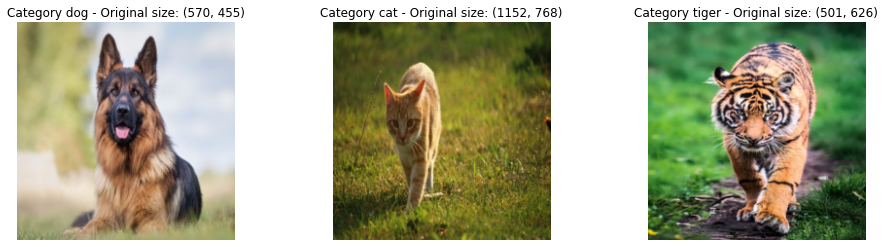

Selected layers: {'block1_conv1'}
Selected layers: {'block1_conv1'}
Selected layers: {'block1_conv1'}


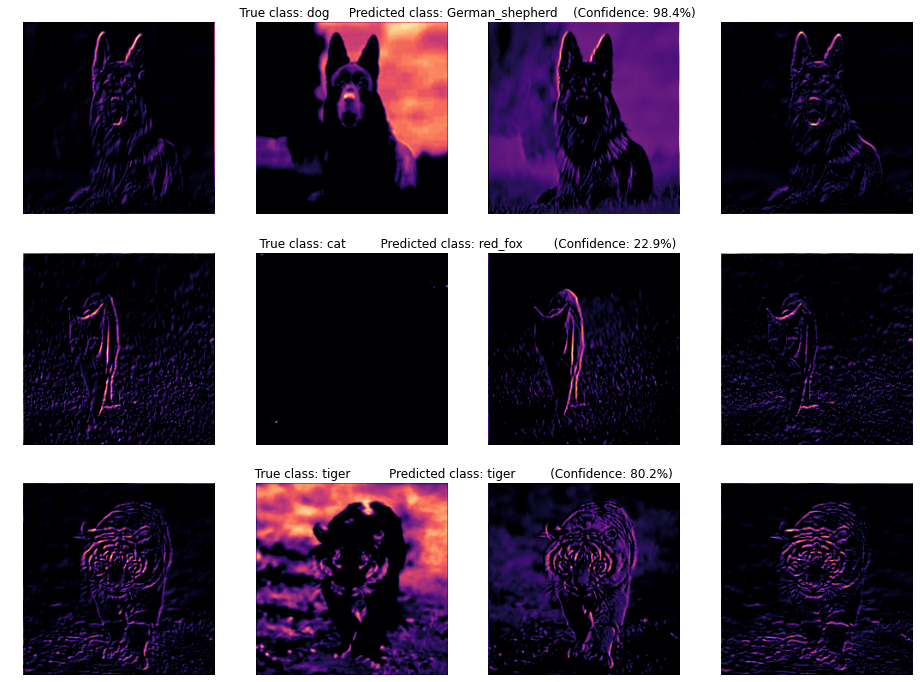

In [117]:
_, ax = plt.subplots(1, 3, figsize=(16, 4))
for img, ax_, label in zip(images, ax, ["dog", "cat", "tiger"]):
    ax_.imshow(img.resize((224, 224), Image.BILINEAR)) # resize image and plot
    ax_.axis('off')
    ax_.set_title("Category {} - Original size: {}".format(label, img.size), fontsize=12)
plt.show()

_, ax = plt.subplots(3, 4, figsize=(16, 12))
[ax_.axis('off') for ax_ in ax.ravel()] # Hide axis
for i, img_, label in zip(range(3), images, ["dog", "cat", "tiger"]):
    predicted = model.predict(preprocess_image(img_))
    class_id, pred_label, prob = np.array(tf.keras.applications.vgg16.decode_predictions(predicted, top=1000))[0, 0]
    ax[i,1].set_title("{:>75} {:^40}(Confidence: {:.1f}%)".format(f"True class: {label}", f"Predicted class: {pred_label}", 
                        100*np.round(prob.astype(float), 3), y=1.02))
    pipeline(img_, model, [1], 4, ax=ax[i], inloop=True)
    
plt.show()

In [167]:
predictions = {label: {"top_10_labels": [], "top_10_prob": []} for label in ["dog", "cat", "tiger"]}

for img_, label in zip(images, ["dog", "cat", "tiger"]):
    predicted = model.predict(preprocess_image(img_))
    class_id, pred_label, prob = np.array(tf.keras.applications.vgg16.decode_predictions(predicted, top=10))[0].T
    predictions[label]["top_10_labels"] = pred_label.tolist()
    predictions[label]["top_10_prob"] = prob.astype(float).tolist()

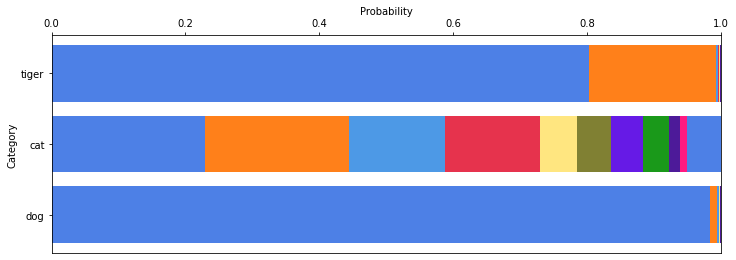

In [280]:
_, ax = plt.subplots(figsize = (12, 4))

for label in ["dog", "cat", "tiger"]:
    widths = predictions[label]["top_10_prob"]
    widths += [1-np.sum(widths)]
    starts = np.cumsum(widths) - widths
    ax.barh(label, widths, left=starts, color=colors)
    
ax.set_ylabel("Category")
ax.xaxis.set_label_position('top')
ax.tick_params(bottom=False, labelbottom=False, top=True, labeltop=True)
ax.set_xlabel("Probability")
plt.show()
